# CTA 3.0

In [1]:
import pandas as pd
import numpy as np

from cvx.simulator import FuturesBuilder
from cvx.simulator.utils.interpolation import interpolate

In [2]:
# Load prices
prices = pd.read_csv("data/Prices_hashed.csv", index_col=0, parse_dates=True)

# interpolate the prices
prices = prices.apply(interpolate)

We use the system:
$$\mathrm{CashPosition}=\frac{f(\mathrm{Price})}{\mathrm{Volatility(Returns)}}$$

This is very problematic:
* Prices may live on very different scales, hence trying to find a more universal function $f$ is almost impossible. The sign-function was a good choice as the results don't depend on the scale of the argument.
* Price may come with all sorts of spikes/outliers/problems.

We need a simple price filter process
* We compute volatility-adjusted returns, filter them and compute prices from those returns. 
* Don't call it Winsorizing in Switzerland. We apply Huber functions. 


In [3]:
def filter(price, volatility=32,clip=4.2, min_periods=300):    
    r = np.log(price).diff()
    vola = r.ewm(com=volatility, min_periods=min_periods).std()
    price_adj = (r/vola).clip(-clip, clip).cumsum()
    return price_adj

### Oscillators
* All prices are now following a standard arithmetic Brownian motion with std $1$.
* What we want is the difference of two moving means (exponentially weighted) to have a constant std regardless of the two lengths.
* An oscillator is the **scaled difference of two moving averages**.


In [4]:
def osc(prices, fast=32, slow=96, scaling=True):
    diff = prices.ewm(com=fast-1).mean() - prices.ewm(com=slow-1).mean()
    if scaling:
        # attention this formula is forward-looking 
        s = diff.std()
        # you may want to use
        #   f,g = 1 - 1/fast, 1-1/slow
        #   s = np.sqrt(1.0 / (1 - f * f) - 2.0 / (1 - f * g) + 1.0 / (1 - g * g))
        # or a moving std
    else:
        s = 1

    return diff/s

In [5]:
from numpy.random import randn

price = pd.Series(data=randn(100000)).cumsum()

o = osc(price, 40, 200, scaling=True)
print("The std for the oscillator (Should be close to 1.0):")
print(np.std(o))

The std for the oscillator (Should be close to 1.0):
0.9999949999874999


In [6]:
#from pycta.signal import osc

# take two moving averages and apply tanh
def f(price, slow=96, fast=32, vola=96, clip=3):
    # construct a fake-price, those fake-prices have homescedastic returns
    price_adj = filter(price, volatility=vola, clip=clip)
    # compute mu
    mu = np.tanh(osc(price_adj, fast=fast, slow=slow))
    return mu/price.pct_change().ewm(com=slow, min_periods=300).std()

In [7]:
from ipywidgets import Label, HBox, VBox, IntSlider, FloatSlider

fast = IntSlider(min=4, max=192, step=4, value=32)
slow = IntSlider(min=4, max=192, step=4, value=96)
vola = IntSlider(min=4, max=192, step=4, value=32)
winsor = FloatSlider(min=1.0, max=6.0, step=0.1, value=4.2)
left_box = VBox([Label("Fast Moving Average"), Label("Slow Moving Average"), Label("Volatility"), Label("Winsorizing")])
right_box = VBox([fast, slow, vola, winsor])
HBox([left_box, right_box])

In [8]:
portfolio = build_portfolio(prices=prices, 
                            cashposition=1e5*f(prices, 
                                               slow=slow.value, 
                                               fast=fast.value, 
                                               vola=vola.value, 
                                               clip=winsor.value),
                           aum=1e8)

/home/thomas/projects/cs/.venv/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/tmp/ipykernel_1338437/3102603862.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  return mu/price.pct_change().ewm(com=slow, min_periods=300).std()


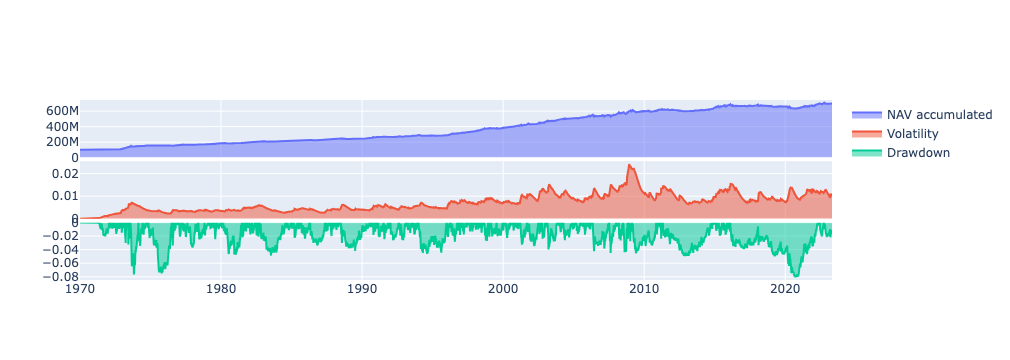

In [9]:
portfolio.snapshot()

In [10]:
pd.set_option('display.precision', 2)
portfolio.metrics()

Sharpe                        0.83
Kurtosis                      8.29
Skewness                     -0.43
Annualized Volatility (%)    12.99
Annualized Return (%)        10.84
